# R4 on DECOY_MNIST

In [16]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from models.fully_connected import FCNAugmented
from models.robust_regularizer import input_gradient_interval_regularizer, input_gradient_pgd_regularizer
from models.pipeline import train_model_with_certified_input_grad, train_model_with_pgd_robust_input_grad, test_model_accuracy, test_delta_input_robustness, write_results_to_file
from datasets import decoy_mnist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pre-train the model

In [2]:
# set up pre-training
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)

cuda:1


In [3]:
batch_size = 1000
dl_train, dl_test = decoy_mnist.get_dataloaders(train_batchsize=batch_size, test_batchsize=batch_size)

/homes/mg2720/phd/R4/examples/datasets/decoy_mnist.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_imgs = torch.tensor(train_imgs.clone().detach(), dtype=torch.float32) / 255
/homes/mg2720/phd/R4/examples/datasets/decoy_mnist.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_imgs = torch.tensor(test_imgs.clone().detach(), dtype=torch.float32) / 255
/homes/mg2720/phd/R4/examples/datasets/decoy_mnist.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels.clone().detach(), dtype=torch

In [4]:
dl_masks_train, dl_masks_test = decoy_mnist.get_masked_dataloaders(dl_train, dl_test)

torch.Size([60000]) torch.Size([60000, 28, 28])
{0: tensor(0.3333), 1: tensor(0.2980), 2: tensor(0.2667), 3: tensor(0.2353), 4: tensor(0.2000), 5: tensor(0.1686), 6: tensor(0.1373), 7: tensor(0.1020), 8: tensor(0.0706), 9: tensor(0.0392)}


In [5]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx):
    batch_input, batch_labels, batch_mask = batch_input.to(device), batch_labels.to(device), batch_mask.to(device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4", batch_masks=batch_mask
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    ax[0][0].imshow(batch_input[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(batch_mask[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_u, ax=ax[1][1])
    im_dx_n = ax[2][0].imshow(dx_n[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [33]:
ARCH = (784, 10, 512, 1)
model = FCNAugmented(*ARCH)
criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)
print(model)

FCNAugmented(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=10, bias=True)
  (4): Softmax(dim=-1)
)


Batch input shape: torch.Size([1000, 28, 28]), batch mask shape: torch.Size([1000, 28, 28])


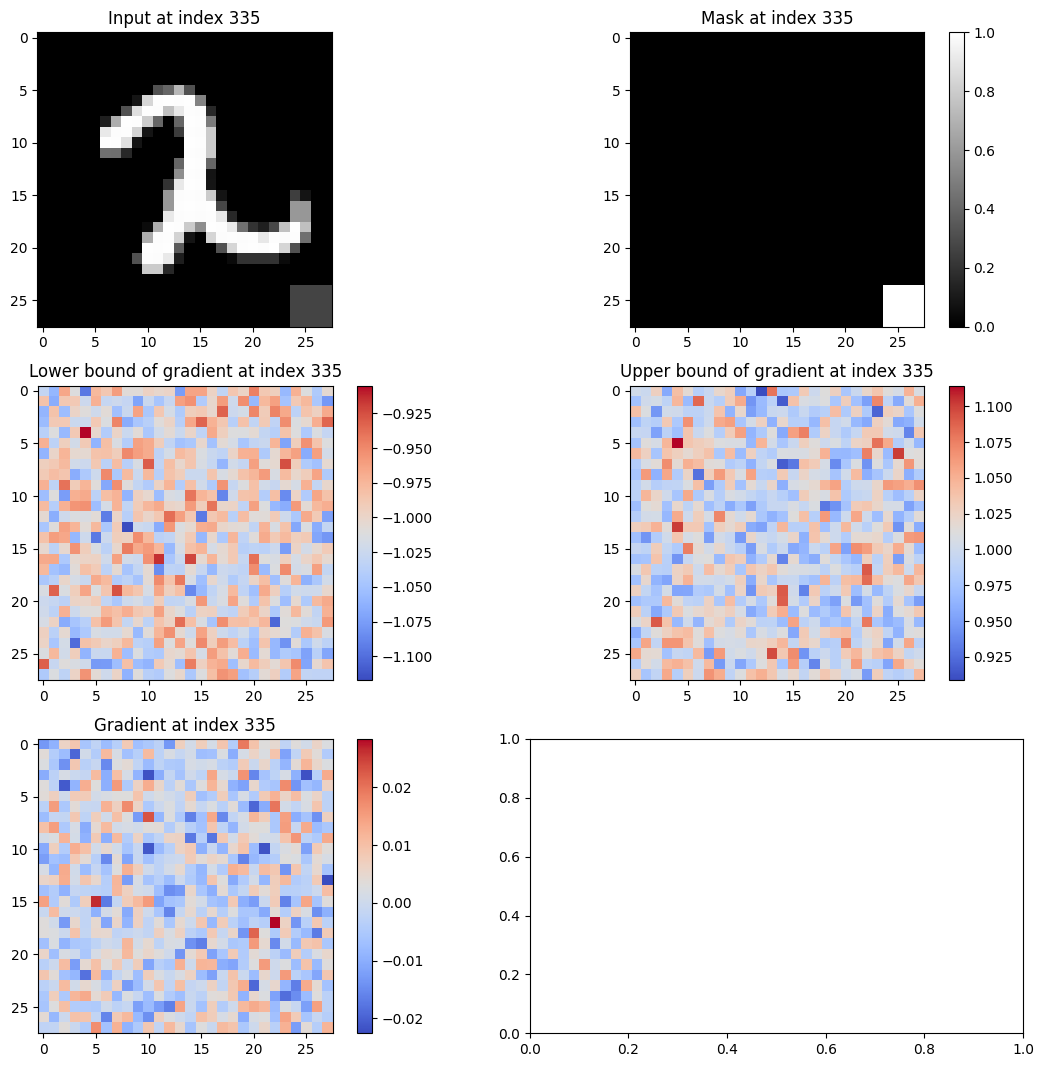

In [7]:
idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
init_batch_train_with_masks = next(iter(dl_masks_train))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
visualize_gradient(model, *init_batch_train_with_masks, epsilon, idx_to_visualize)

## Experiments 

In [8]:
DELTA_INPUT_ROBUSTNESS_PARAM = 0.5

### Standard Training

In [34]:
std_method = "std"
# hyperparameters
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.01, 4, 0.1, 0.01, 0.2
# Train standard 3 times and test accuracy and delta input robustness for the masked region
train_acc, test_acc, num_robust, min_robust_delta = 0, 0, 0, 1e+8
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, False)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta = test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    # test_with_masks_batch = next(iter(dl_masks_test))
    # test_idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
    # if i == restarts - 1:
    #     visualize_gradient(curr_model, *test_with_masks_batch, epsilon, test_idx_to_visualize)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_robust_delta": min_robust_delta}, std_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, std_method)

========== Training model with method std restart 0 ==========


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 100%|██████████| 30/30 [00:35<00:00,  1.18s/it, loss=1.46, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.67
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 526
========== Training model with method std restart 1 ==========


Epoch: 100%|██████████| 30/30 [00:35<00:00,  1.17s/it, loss=1.46, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.67
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 470
========== Training model with method std restart 2 ==========


Epoch: 100%|██████████| 30/30 [00:34<00:00,  1.16s/it, loss=1.46, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.66
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 491
========== Training model with method std restart 3 ==========


Epoch: 100%|██████████| 30/30 [00:34<00:00,  1.15s/it, loss=1.46, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.68
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 502


### RRR Training

In [39]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
def rrr_k_schedule(curr_epoch, max_epochs, std_loss, rrr_loss):
    if curr_epoch <= max_epochs // 5:
        return 0.0
    else:
        # get magnitude difference in terms of order of magnitude
        loss_diff = rrr_loss - std_loss
        if loss_diff < 0:
            return 1.0
        orders_of_mag = torch.floor(torch.log10(loss_diff))
        # the 2 is there to allow for a bit of a margin
        return 1 / (2 * (10 ** (orders_of_mag - 1)))

# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 20, 0.01, 4, 0.1, 6e-3, 0.05
train_acc, test_acc, num_robust, min_robust_delta = 0, 0, 0, 1e+8
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method,
                                          k, device, False, k_schedule=rrr_k_schedule, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta = test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "cross_entropy", device)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    # if i == restarts - 1:
    #     visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_robust_delta": min_robust_delta}, rrr_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, rrr_method)

========== Training model with method r3, restart 0 ==========


Epoch: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it, loss=23.3, reg=tensor(435.4988, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.98
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.88
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 10.6
========== Training model with method r3, restart 1 ==========


Epoch: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it, loss=10.4, reg=tensor(178.4988, device='cuda:1', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.98
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.89
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 11.1
========== Training model with method r3, restart 2 ==========


Epoch: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it, loss=11.4, reg=tensor(198.7878, device='cuda:1', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.98
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.89
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 11.6
========== Training model with method r3, restart 3 ==========


Epoch: 100%|██████████| 20/20 [00:27<00:00,  1.35s/it, loss=15.7, reg=tensor(283.6178, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.98
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.89
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 11


In [42]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
num_epochs, lr, restarts, epsilon, weight_coeff, k = 25, 0.02, 4, 0.1, -1, 1
train_acc, test_acc, num_robust, min_robust_delta = 0, 0, 0, 1e+8
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, device, False)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta = test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    # if i == restarts - 1:
    #     visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize)

write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_robust_delta": min_robust_delta}, r4_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, r4_method)

========== Training model with method R4, restart 0 ==========


Epoch: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, loss=1.48, reg=tensor(0.0087, device='cuda:1', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.99
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.98
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.516
========== Training model with method R4, restart 1 ==========


Epoch: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, loss=1.48, reg=tensor(0.0077, device='cuda:1', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.99
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.98
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.538
========== Training model with method R4, restart 2 ==========


Epoch: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it, loss=1.48, reg=tensor(0.0077, device='cuda:1', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.99
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.98
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.543
========== Training model with method R4, restart 3 ==========


Epoch: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, loss=1.48, reg=tensor(0.0083, device='cuda:1', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.99
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.98
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0.58


IBP-EX Training

In [51]:
ibp_ex_method = "ibp_ex"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.02, 4, 0.1, 8e-3, 0.12
train_acc, test_acc, num_robust, min_robust_delta = 0, 0, 0, 1e+8
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {ibp_ex_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_method, k,
                                          device, False, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta = test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    # if i == restarts - 1:
    #     visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize)

write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_robust_delta": min_robust_delta}, ibp_ex_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, ibp_ex_method)

========== Training model with method ibp_ex restart 0 ==========


Epoch: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it, loss=1.58, reg=tensor(4.5065, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.98
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.81
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 18.5


## PGD Training 

### PGD_EX

========== Training model with method pgd_ex restart 0 ==========


Epoch: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=1.8, reg=tensor(1.6235, device='cuda:1', grad_fn=<AddBackward0>)]


--- Model accuracy ---
Nominal = 0.96
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 30.7


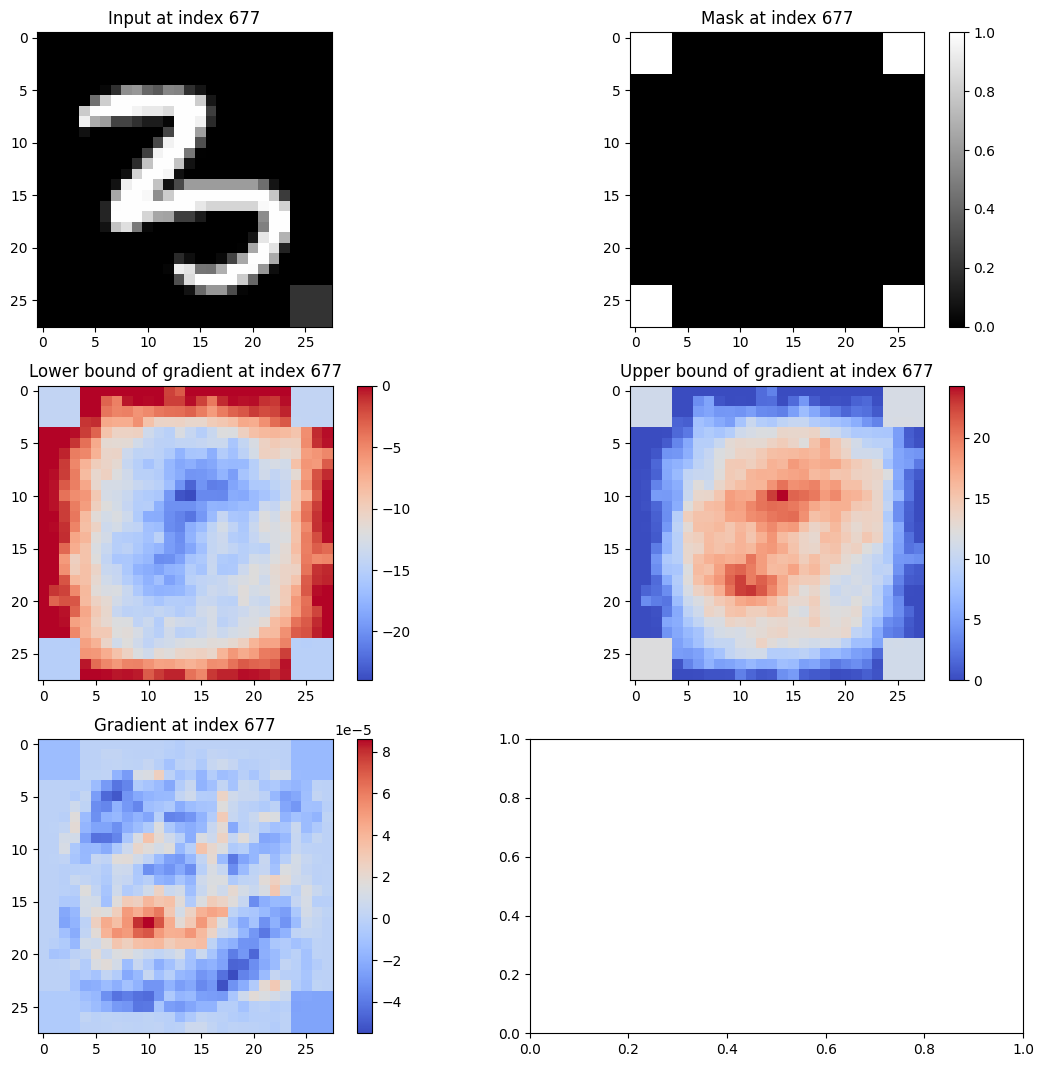

In [78]:
pgd_ex = "pgd_ex"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH).to(device)

    print(f"========== Training model with method {pgd_ex} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_ex, k, device)
    test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "cross_entropy", device)
    test_with_masks_batch = next(iter(dl_masks_test))
    test_idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
    if i == restarts - 1:
        visualize_gradient(curr_model, *test_with_masks_batch, epsilon, test_idx_to_visualize)

In [79]:
### R4 with PGD

========== Training model with method ibp_ex restart 0 ==========


Epoch: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it, loss=1.47, reg=tensor(1.8519e-06, device='cuda:1')]


--- Model accuracy ---
Nominal = 0.69
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 190


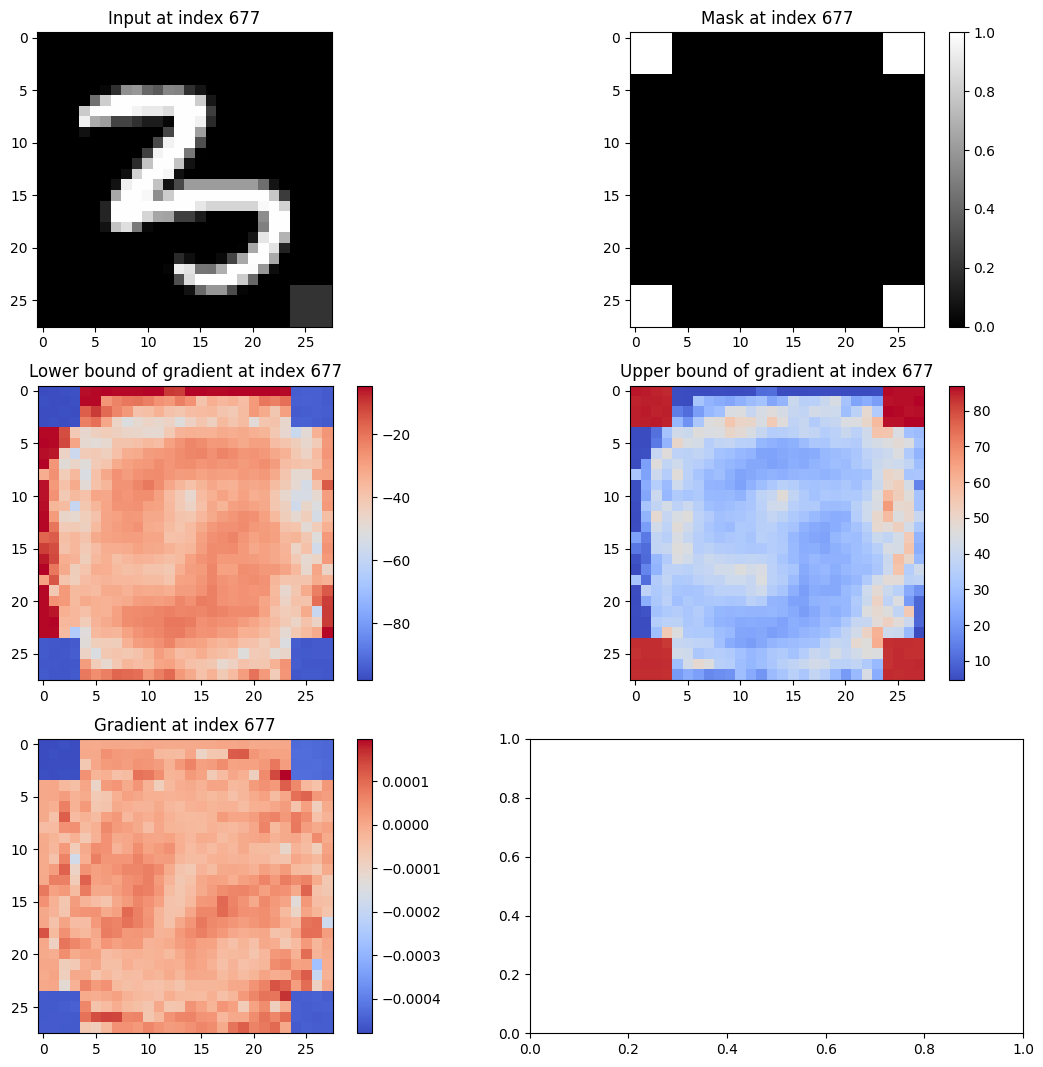

In [80]:
r4_pgd = "r4"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH).to(device)

    print(f"========== Training model with method {ibp_ex_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, r4_pgd, k, device)
    test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "cross_entropy", device)
    test_with_masks_batch = next(iter(dl_masks_test))
    test_idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
    if i == restarts - 1:
        visualize_gradient(curr_model, *test_with_masks_batch, epsilon, test_idx_to_visualize)